# **Team 8: the 3rd Bulgarian empire - Iteration 3 Notebook**
### Predicting Dwelling Restoration Needs
You are a team of data analysts working for RenovateNow, a property management company specializing in acquiring enchanted dwellings that require restoration. The company wants to streamline its selection process by predicting whether a dwelling requires significant restoration (NeedsRestoration = True) or not (NeedsRestoration = False). Additionally, they want to refine their understanding of trade values by creating a more accurate regression model. 

In [321]:
# General & data preparation
import pandas as pd

# Data vizualization
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model and evaluation
import sklearn as scikit_learn
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [277]:
# Load the datasets
df_it2 = pd.read_csv("Data/set8_it2_cleaned.csv")
df_it3 = pd.read_csv("Data/set8_it3.csv")

## **DATA UNDERSTANDING - add on dataset**

In [278]:
df_it2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2318 entries, 0 to 2317
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DI                   2318 non-null   int64  
 1   TradeValue           2318 non-null   float64
 2   RealmType            2318 non-null   object 
 3   Enclave              2318 non-null   object 
 4   LivingQuarters       2318 non-null   float64
 5   ParcelSize           2318 non-null   float64
 6   ParcelSizeUnit       2318 non-null   object 
 7   StructuralIntegrity  2318 non-null   int64  
 8   ExteriorCharm        2318 non-null   object 
 9   Downpayment          2318 non-null   float64
 10  LoanAmount           2318 non-null   float64
 11  MonthlyPayment       2318 non-null   float64
 12  AffordableDwelling   2318 non-null   int64  
dtypes: float64(6), int64(3), object(4)
memory usage: 235.6+ KB


In [279]:
df_it3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   DI              2363 non-null   int64
 1   Craftsmanship   2363 non-null   int64
 2   EraConstructed  2363 non-null   int64
dtypes: int64(3)
memory usage: 55.5 KB


## **DATA PREPARATION**
* Initial merging of the cleaned dataset and the add-on dataset
* Cleaning duplicates to not have any missing values
* Setting initial calculations based on the income, loan, downpayments, etc

In [280]:
# Remove duplicate rows
df_it3 = df_it3.drop_duplicates()

# left merge on the cleaned dataset
df = df_it2.merge(df_it3, on='DI', how='left', indicator=True)

In [281]:
df.sample(7)

,DI,TradeValue,RealmType,Enclave,LivingQuarters,ParcelSize,ParcelSizeUnit,StructuralIntegrity,ExteriorCharm,Downpayment,LoanAmount,MonthlyPayment,AffordableDwelling,Craftsmanship,EraConstructed,_merge
247,248,185750.0,Meadowlands,Nighthaven,1145.0,9156.0,sqft,7,Common,37150.0,148600.0,709.439129,1,6,1387,both
2174,2196,415000.0,Meadowlands,Silverglen,1436.0,14780.0,sqft,5,Enchanting,83000.0,332000.0,1585.018781,0,9,1761,both
1768,1784,271000.0,Meadowlands,Glimmerwood,1636.0,10944.0,sqft,5,Gleaming,54200.0,216800.0,1035.036361,0,7,1550,both
1312,1327,142500.0,GnomeBurough,Shadowmere,824.0,3675.0,sqft,5,Common,28500.0,114000.0,544.253437,1,6,1610,both
1435,1451,190000.0,Meadowlands,Windwhisper,1117.0,5271.0,sqft,5,Common,38000.0,152000.0,725.671249,1,7,1402,both
2118,2138,131000.0,Meadowlands,Shadowmere,1319.0,11409.0,sqft,4,Common,26200.0,104800.0,500.331230,1,5,1173,both
1319,1334,159000.0,Meadowlands,Dragonspire,966.0,8000.0,sqft,6,Common,31800.0,127200.0,607.272256,1,5,1364,both


A dwelling needs restoration if it was built before 1300 and if the StructuralIntegrity is 6 or less.

In [282]:
# Create NeedsRestoration column with 1 being that the dwelling needs restoration and 0 meaning that it doesn't.
df['NeedsRestoration'] = ((df['EraConstructed'] < 1300) & (df['StructuralIntegrity'] <= 6)).astype(int)

# Display the first few rows of the merged DataFrame
df.head()

,DI,TradeValue,RealmType,Enclave,LivingQuarters,ParcelSize,ParcelSizeUnit,StructuralIntegrity,ExteriorCharm,Downpayment,LoanAmount,MonthlyPayment,AffordableDwelling,Craftsmanship,EraConstructed,_merge,NeedsRestoration
0,0,125000.0,Meadowlands,Shadowmere,1032.0,9280.0,sqft,6,Common,25000.0,100000.0,477.415295,1,5,1294,both,1
1,1,250000.0,Meadowlands,Ravenstone,1933.0,11170.0,sqft,5,Common,50000.0,200000.0,954.830591,0,7,1442,both,0
2,2,130000.0,GnomeBurough,Petalbridge,1012.0,5500.0,sqft,7,Common,26000.0,104000.0,496.511907,1,5,1052,both,0
3,3,157500.0,Meadowlands,Emberfall,843.0,13014.0,sqft,5,Common,31500.0,126000.0,601.543272,1,6,1512,both,0
4,4,156000.0,Meadowlands,Dragonspire,807.0,8092.0,sqft,8,Common,31200.0,124800.0,595.814289,1,6,1316,both,0


In [351]:
df.describe()

,DI,TradeValue,LivingQuarters,ParcelSize,StructuralIntegrity,Downpayment,LoanAmount,MonthlyPayment,AffordableDwelling,Craftsmanship,EraConstructed,NeedsRestoration
count,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000,2318.000000
mean,1169.446074,182213.303279,1155.320104,10060.294507,5.566005,36442.660656,145770.642623,695.931344,0.692839,6.118637,1409.698016,0.220449
std,676.195944,82064.948640,386.398111,7158.773125,1.107786,16412.989728,65651.958912,313.432494,0.461416,1.413660,231.823354,0.414639
min,0.000000,12789.000000,256.000000,1470.000000,1.000000,2557.800000,10231.200000,48.845314,0.000000,1.000000,887.000000,0.000000
25%,583.250000,129900.000000,879.000000,7410.250000,5.000000,25980.000000,103920.000000,496.129975,0.000000,5.000000,1228.000000,0.000000
50%,1170.500000,160500.000000,1110.500000,9378.500000,5.000000,32100.000000,128400.000000,613.001239,1.000000,6.000000,1396.000000,0.000000
75%,1753.750000,213220.750000,1329.000000,11546.250000,6.000000,42644.150000,170576.600000,814.358779,1.000000,7.000000,1617.750000,0.000000
max,2339.000000,755000.000000,4339.000000,164660.000000,9.000000,151000.000000,604000.000000,2883.588385,1.000000,10.000000,1799.000000,1.000000


## **DATA UNDERSTANDING**

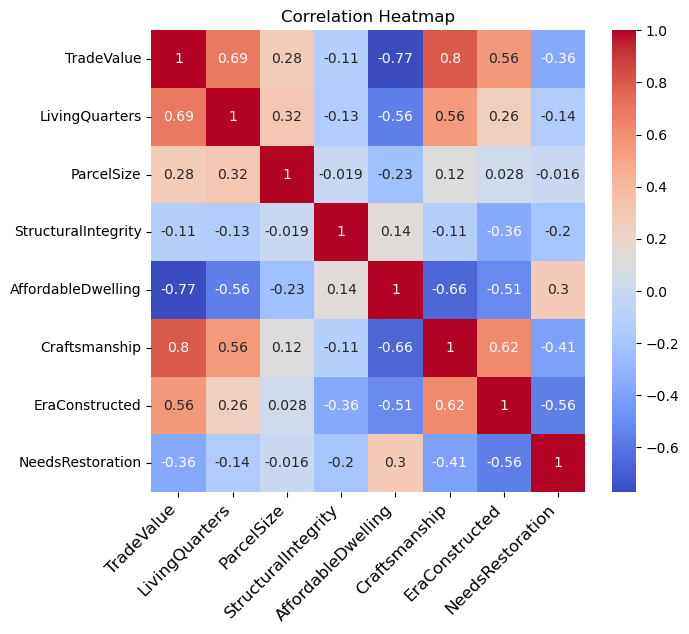

In [283]:
# We are transforming the categorical data into numerical using the label encoder
df2 = df.copy()
df2 = df2.drop(columns=["ParcelSizeUnit", "DI", "Downpayment", "MonthlyPayment", "LoanAmount", "RealmType", "Enclave", "ExteriorCharm", "_merge"])

# Visualize the correlation with a heatmap
plt.figure(figsize=(7, 6))
sns.heatmap(df2.corr(), annot=True, cmap="coolwarm")
plt.xticks(ha='right', rotation=45, fontsize=12)
plt.title("Correlation Heatmap")
plt.show()

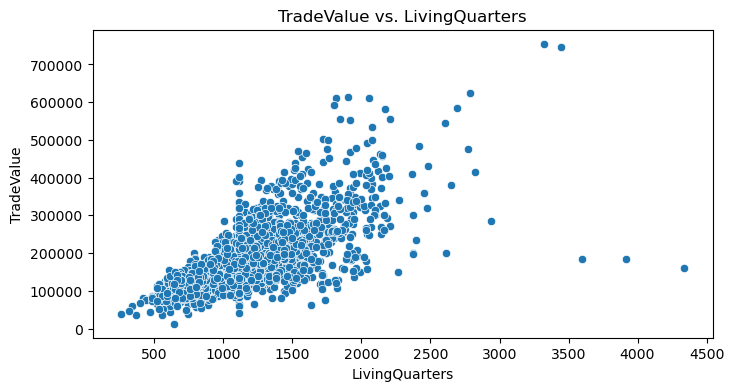

In [284]:
# Scatterplot for TradeValue vs. LivingQuarters
plt.figure(figsize=(8, 4))
sns.scatterplot(data=df, x='LivingQuarters', y='TradeValue')
plt.title('TradeValue vs. LivingQuarters')
plt.show()

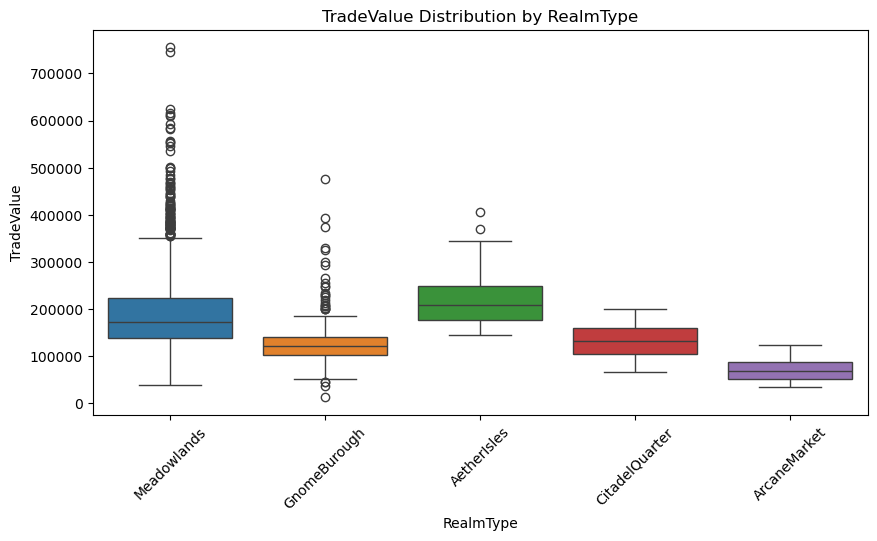

In [285]:
# Violin Plot for TradeValue vs. RealmType (to see value distribution across different realms)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='RealmType', y='TradeValue', hue='RealmType')
plt.title('TradeValue Distribution by RealmType')
plt.xticks(rotation=45)
plt.show()

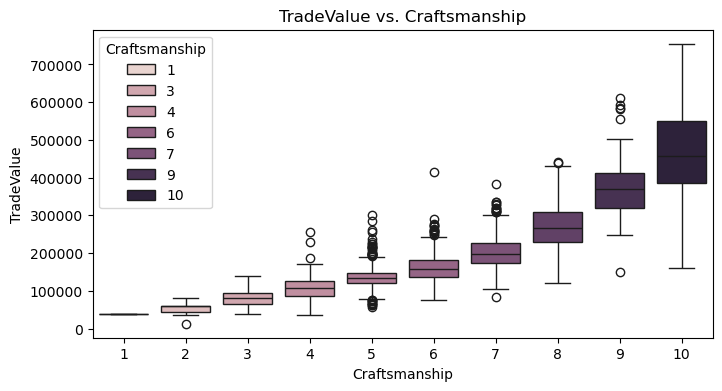

In [286]:
# Boxplot for TradeValue vs. Craftsmanship (ordinal variable)
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='Craftsmanship', y='TradeValue', hue='Craftsmanship')
plt.title('TradeValue vs. Craftsmanship')
plt.show()

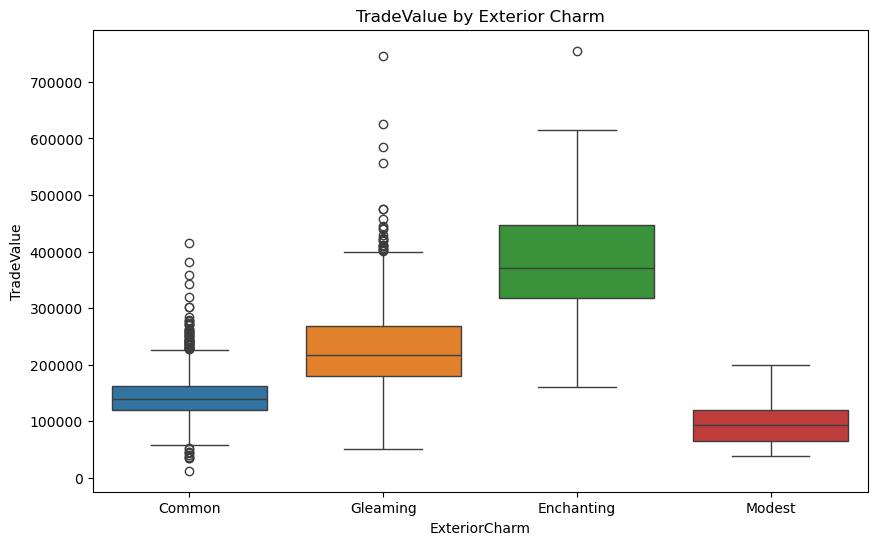

In [287]:
# Boxplot for TradeValue by ExteriorCharm
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='ExteriorCharm', y='TradeValue', hue='ExteriorCharm')
plt.title('TradeValue by Exterior Charm')
plt.show()

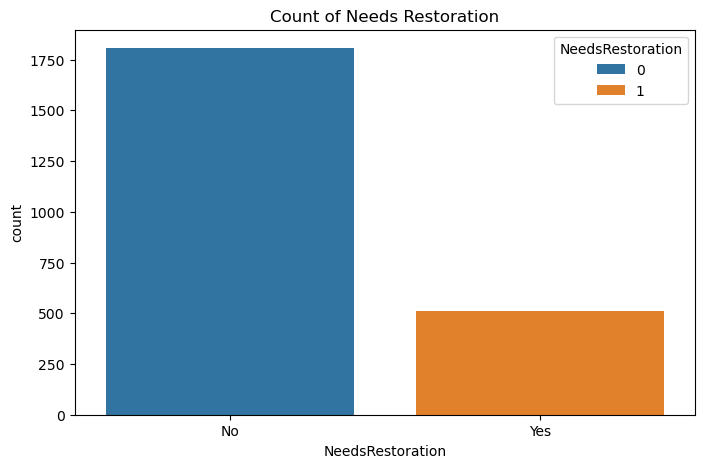

In [288]:
# Count plot for NeedsRestoration
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='NeedsRestoration', hue='NeedsRestoration')
plt.title('Count of Needs Restoration')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

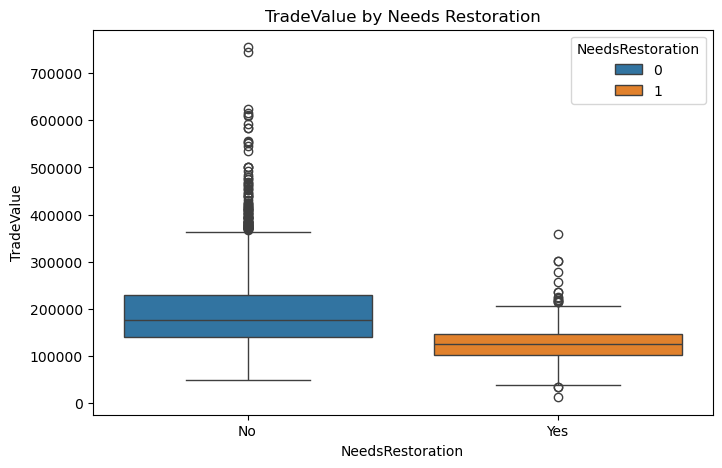

In [289]:
# Boxplot for TradeValue by NeedsRestoration
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='NeedsRestoration', y='TradeValue', hue='NeedsRestoration')
plt.title('TradeValue by Needs Restoration')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

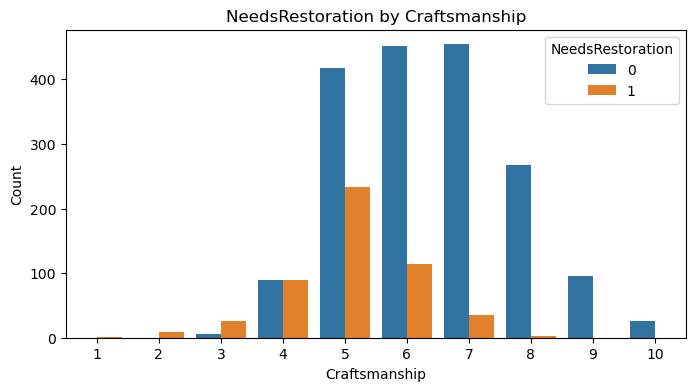

In [290]:
# Countplot for Craftsmanship vs NeedsRestoration
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Craftsmanship', hue='NeedsRestoration')
plt.title('NeedsRestoration by Craftsmanship')
plt.xlabel('Craftsmanship')
plt.ylabel('Count')
plt.show()

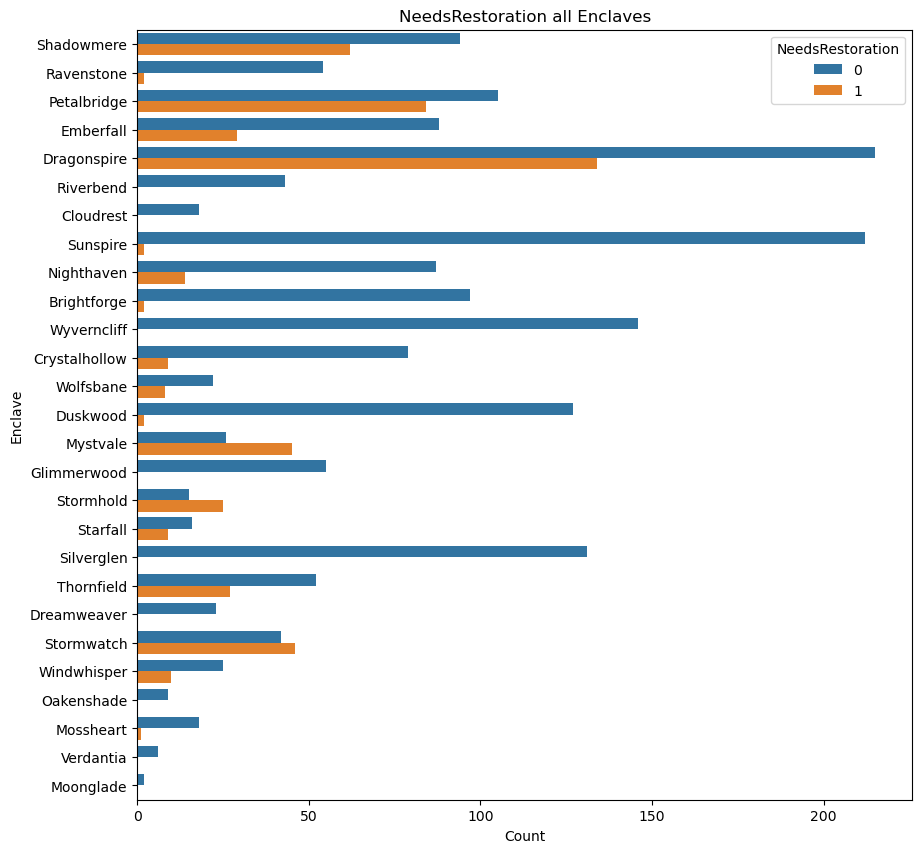

In [352]:
# Countplot for Enclave vs NeedsRestoration (Top 10 most common Enclaves)
top_enclaves = df['Enclave'].value_counts().nlargest(30).index
df_top_enclaves = df[df['Enclave'].isin(top_enclaves)]

plt.figure(figsize=(10, 10))
sns.countplot(data=df_top_enclaves, y='Enclave', hue='NeedsRestoration')
plt.title('NeedsRestoration all Enclaves')
plt.xlabel('Count')
plt.ylabel('Enclave')
plt.show()

## **MODEL**

### Linear regression model

In [349]:
df_encoded = df.copy()
y = df_encoded['TradeValue']

# One-Hot Encode nominal categorical features
df_encoded = pd.get_dummies(df_encoded, columns=["ExteriorCharm", "RealmType", "Enclave"], drop_first=True)

X = df_encoded.drop(columns=[
    "ParcelSizeUnit", "DI", "TradeValue", "_merge",
    "Downpayment", "LoanAmount", "MonthlyPayment", 
])

# Assign the data (80% of the data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)  

# Fit in the data and trained it to make predictions
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

## **Evaluation - Linear Regression Model**

In [348]:
# After the predictions we are using metrics such as Mean Absolute Error and Mean squared error to see what the efficiency of our model is both on the train and the test data
print(f"MAE - Mean Absolute Error")
print(f"MAE for the linear model on the test set: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"MAE for the linear model on the training set: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"\nMSE - Mean Square Error")
print(f"MSE for the linear model on the test set: {mean_squared_error(y_test, y_pred_test):.2f}")
print(f"MSE for the linear model on the training set: {mean_squared_error(y_train, y_pred_train):.2f}")
print(f"\nRMSE - Root Mean Square Error")
print(f"RMSE for the linear model on the test set: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}")
print(f"RMSE for the linear model on the training set: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

MAE - Mean Absolute Error
MAE for the linear model on the test set: 20470.13
MAE for the linear model on the training set: 19446.31

MSE - Mean Square Error
MSE for the linear model on the test set: 1104503677.47
MSE for the linear model on the training set: 966553342.26

RMSE - Root Mean Square Error
RMSE for the linear model on the test set: 33234.07
RMSE for the linear model on the training set: 31089.44


## **MODEL**

### Classification model - using tree
A decision tree model is made to classify whether a dwelling needs restoration. The decision tree structure is vizualized.

In [357]:
features = df[['TradeValue', 'Craftsmanship', 'EraConstructed']]
target = df['NeedsRestoration']
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)  

model = tree.DecisionTreeClassifier(max_depth=2, class_weight='balanced')
model.fit(feature_train, target_train)
y_pred_test = model.predict(feature_test)
y_pred_train = model.predict(feature_train)

print(f'Accuracy for the train set: {np.sqrt(accuracy_score(target_train, y_pred_train)):.2f}')
print(confusion_matrix(target_train, y_pred_train, normalize='all', labels=[True, False]))
print(f'Accuracy for the test set: {np.sqrt(accuracy_score(target_test, y_pred_test)):.2f}')
print(confusion_matrix(target_test, y_pred_test, normalize='all', labels=[True, False]))

Accuracy for the train set: 0.94
[[0.2188656  0.00308261]
 [0.12083847 0.65721332]]
Accuracy for the test set: 0.94
[[0.21408046 0.00287356]
 [0.11206897 0.67097701]]


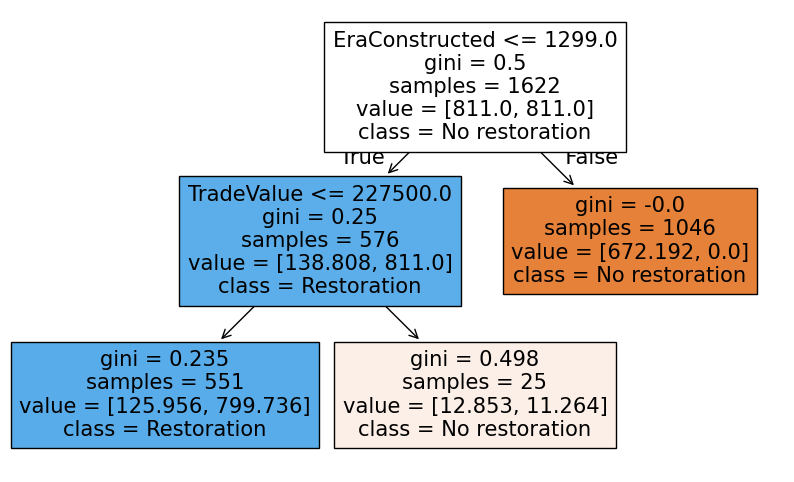

In [358]:
plt.figure(figsize=(10,6))
tree.plot_tree(model, feature_names=features.columns, class_names=['No restoration', 'Restoration'], filled=True)
plt.show()

## **Evaluation - classification model using tree**

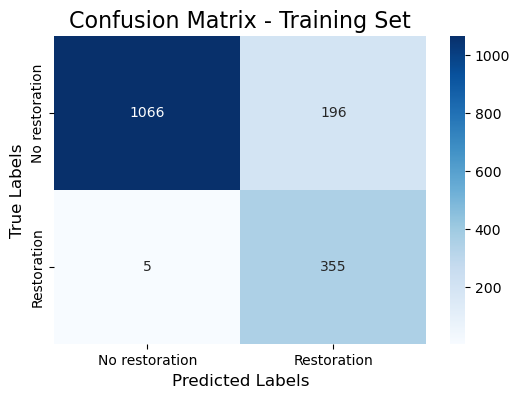

In [359]:
cm = confusion_matrix(target_train, y_pred_train)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No restoration', 'Restoration'], yticklabels=['No restoration', 'Restoration'])
plt.title('Confusion Matrix - Training Set', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

In [360]:
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(target_train, y_pred_train)
precision = precision_score(target_train, y_pred_train)
recall = recall_score(target_train, y_pred_train)
f1 = f1_score(target_train, y_pred_train)
roc_auc = roc_auc_score(target_train, y_pred_train)
misclassification_rate = (FP + FN) / (TP + TN + FP + FN)

print(f"Accuracy: {round(accuracy, 2)}")
print(f"Precision: {round(precision, 2)}")
print(f"Recall: {round(recall, 2)}")
print(f"F1 Score: {round(f1, 2)}")
print(f"Misclassification Rate: {round(misclassification_rate, 2)}")

Accuracy: 0.88
Precision: 0.64
Recall: 0.99
F1 Score: 0.78
Misclassification Rate: 0.12
